✅ Arquivo salvo com 480 linhas em SBBE202510070000merged.csv
LCL Pressure: 991 hPa, LCL Height: 0 km
EL Pressure: 219 hPa, EL Height: 11 km
Cloud Thickness: 11 km


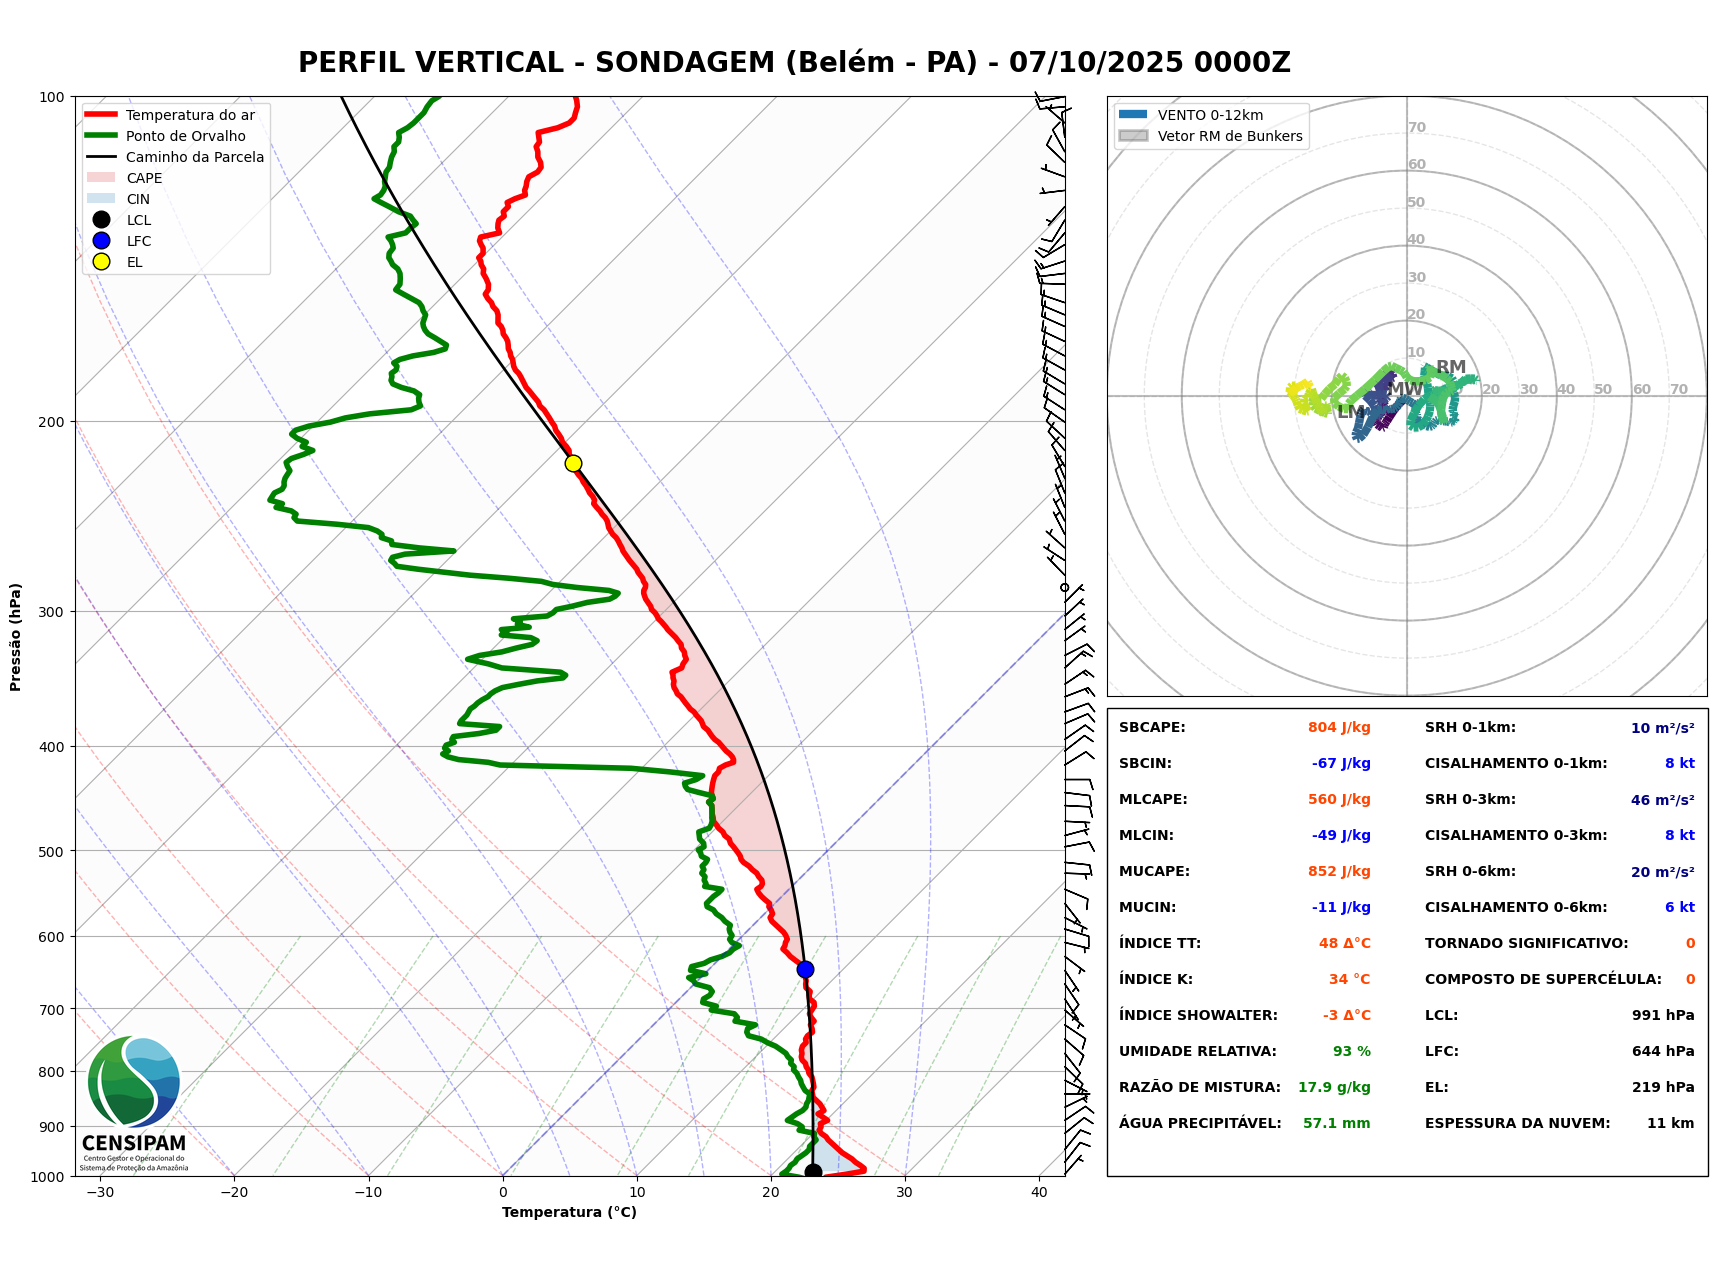

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import metpy.calc as mpcalc
from metpy.plots import Hodograph, SkewT
from metpy.units import units
from PIL import Image
import re
import glob
import os

# Função para ler o arquivo PTU
def read_ptu(filename):
    cols = ["min", "s", "Pressure", "Height", "Temperature", "RH", "DewPoint"]
    data = []
    with open(filename, "r", encoding="latin-1") as f:
        start = False
        for line in f:
            if line.strip().startswith("min"):
                start = True
                continue
            if start:
                parts = re.findall(r"[-+]?\d*\.\d+|\d+", line)
                if len(parts) >= 7:
                    data.append(parts[:7])
    df = pd.DataFrame(data, columns=cols)
    return df.apply(pd.to_numeric, errors="coerce")

# Função para ler o arquivo WIND
def read_wind(filename):
    cols = ["min", "s", "Pressure", "Height", "Speed", "Direction"]
    data = []
    with open(filename, "r", encoding="latin-1") as f:
        start = False
        for line in f:
            if line.strip().startswith("min"):
                start = True
                continue
            if start:
                parts = re.findall(r"[-+]?\d*\.\d+|\d+", line)
                if len(parts) >= 6:
                    data.append(parts[:6])
    df = pd.DataFrame(data, columns=cols)
    return df.apply(pd.to_numeric, errors="coerce")

# Buscando arquivos com o padrão SBBE*WIND.txt e SBBE*PTU.txt
wind_files = glob.glob("SBBE*WIND.txt")
ptu_files = glob.glob("SBBE*PTU.txt")

# Verificando se encontrou exatamente um arquivo de cada tipo
if len(wind_files) != 1:
    raise FileNotFoundError(f"Erro: Encontrado(s) {len(wind_files)} arquivo(s) WIND. Esperado exatamente 1 arquivo com padrão SBBE*WIND.txt")
if len(ptu_files) != 1:
    raise FileNotFoundError(f"Erro: Encontrado(s) {len(ptu_files)} arquivo(s) PTU. Esperado exatamente 1 arquivo com padrão SBBE*PTU.txt")

wind_file = wind_files[0]
ptu_file = ptu_files[0]

# Extraindo a parte comum do nome do arquivo para o CSV de saída
common_name = os.path.basename(wind_file).replace("WIND.txt", "")
output_csv = f"{common_name}merged.csv"

# Lendo arquivos
df_ptu = read_ptu(ptu_file)
df_wind = read_wind(wind_file)

# Fazendo merge pelas colunas comuns
df_merged = pd.merge(df_ptu, df_wind, on=["min", "s", "Pressure", "Height"], how="inner")

# Removendo colunas 'min' e 's' antes de salvar
df_merged.drop(columns=["min", "s"], inplace=True)

# Salvando CSV final
df_merged.to_csv(output_csv, index=False, encoding="utf-8")
print(f"✅ Arquivo salvo com {len(df_merged)} linhas em {output_csv}")

# Lendo os dados do arquivo CSV gerado
col_names = ['pressure', 'height', 'temperature', 'rh', 'dewpoint', 'speed', 'direction']
df = pd.read_csv(output_csv, names=col_names, skiprows=1)

# Removendo linhas com valores NaN para temperatura, ponto de orvalho e ventos
df = df.dropna(subset=('temperature', 'dewpoint', 'direction', 'speed'), how='all').reset_index(drop=True)

# Extraindo variáveis e atribuindo unidades
p = df['pressure'].values * units.hPa
z = df['height'].values * units.m
T = df['temperature'].values * units.degC
Td = df['dewpoint'].values * units.degC
rh = df['rh'].values * units.percent
wind_speed = df['speed'].values * units.knots
wind_dir = df['direction'].values * units.degrees

# Calculando variáveis adicionais necessárias
mixr = mpcalc.mixing_ratio_from_relative_humidity(p, T, rh).to('g/kg')
theta = mpcalc.potential_temperature(p, T).to('kelvin')
theta_e = mpcalc.equivalent_potential_temperature(p, T, Td).to('kelvin')
theta_v = mpcalc.virtual_potential_temperature(p, T, mixr).to('kelvin')
u, v = mpcalc.wind_components(wind_speed, wind_dir)

# Criando a figura com proporções adequadas
fig = plt.figure(figsize=(18, 12))
skew = SkewT(fig, rotation=45, rect=(0.05, 0.05, 0.55, 0.90))

# Adicionando a imagem personalizada (LogoCensipam.png) com tamanho ajustado
logo = Image.open('LogoCensipam.png')
new_size = (int(logo.width * 0.1), int(logo.height * 0.1))
logo_resized = logo.resize(new_size, Image.Resampling.LANCZOS)
logo_array = np.array(logo_resized)
fig.figimage(logo_array, xo=80, yo=100, zorder=10, alpha=1.0)

# Ajustando limites de dados e aparência
skew.ax.set_adjustable('datalim')
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-20, 30)
skew.ax.set_xlabel('Temperatura (°C)', weight='bold')
skew.ax.set_ylabel('Pressão (hPa)', weight='bold')
fig.set_facecolor('#ffffff')
skew.ax.set_facecolor('#ffffff')

# Adicionando padrão de isotermas sombreadas
x1 = np.linspace(-100, 40, 8)
x2 = np.linspace(-90, 50, 8)
y = [1100, 50]
for i in range(8):
    skew.shade_area(y=y, x1=x1[i], x2=x2[i], color='gray', alpha=0.02, zorder=1)

# Plotando temperatura, ponto de orvalho e barbelas de vento na ordem desejada
skew.plot(p, T, 'r', lw=4, label='Temperatura do ar')
skew.plot(p, Td, 'g', lw=4, label='Ponto de Orvalho')
interval = np.logspace(2, 3, 80) * units.hPa
idx = mpcalc.resample_nn_1d(p, interval)
skew.plot_barbs(pressure=p[idx], u=u[idx], v=v[idx], length=6)

# Adicionando linhas especiais e ajustando aparência
skew.ax.axvline(0 * units.degC, linestyle='--', color='blue', alpha=0.3)
skew.plot_dry_adiabats(lw=1, alpha=0.3)
skew.plot_moist_adiabats(lw=1, alpha=0.3)
skew.plot_mixing_lines(lw=1, alpha=0.3)

# Calculando e plotando perfil da parcela
prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')
skew.plot(p, prof, 'k', linewidth=2, label='Caminho da Parcela')

# Sombreando áreas de CAPE e CIN
skew.shade_cape(p, T, prof, alpha=0.2, label='CAPE')
skew.shade_cin(p, T, prof, Td, alpha=0.2, label='CIN')

# Calculando e plotando LCL
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black', label='LCL', zorder=10, markersize=12)

# Calculando e plotando LFC
lfc_pressure, lfc_temperature = mpcalc.lfc(p, T, Td)
if lfc_pressure is not None and lfc_temperature is not None:
    skew.plot(lfc_pressure, lfc_temperature, 'ko', markerfacecolor='blue', label='LFC', zorder=10, markersize=12)

# Calculando e plotando EL
el_pressure, el_temperature = mpcalc.el(p, T, Td)
if el_pressure is not None and el_temperature is not None:
    skew.plot(el_pressure, el_temperature, 'ko', markerfacecolor='yellow', label='EL', zorder=10, markersize=12)

# Calculando a espessura da nuvem (EL - LCL)
if el_pressure is not None and lcl_pressure is not None and el_pressure < lcl_pressure:
    # Usando pressure_to_height_std para calcular alturas
    lcl_height = mpcalc.pressure_to_height_std(lcl_pressure)
    el_height = mpcalc.pressure_to_height_std(el_pressure)
    cloud_thickness = el_height - lcl_height
    
    # Impressões de depuração
    print(f"LCL Pressure: {lcl_pressure:.0f~P}, LCL Height: {lcl_height:.0f~P}")
    print(f"EL Pressure: {el_pressure:.0f~P}, EL Height: {el_height:.0f~P}")
    print(f"Cloud Thickness: {cloud_thickness:.0f~P}")
else:
    cloud_thickness = None
    print(f"EL inválido ou não acima do LCL (LCL Pressure: {lcl_pressure:.0f~P}, EL Pressure: {el_pressure:.0f~P}), espessura da nuvem não calculada.")

# Criando o hodógrafo
hodo_ax = plt.axes((0.54, 0.45, 0.5, 0.5))
h = Hodograph(hodo_ax, component_range=80.)
h.add_grid(increment=20, ls='-', lw=1.5, alpha=0.5)
h.add_grid(increment=10, ls='--', lw=1, alpha=0.2)
h.ax.set_box_aspect(1)
h.ax.set_yticklabels([])
h.ax.set_xticklabels([])
h.ax.set_xticks([])
h.ax.set_yticks([])
h.ax.set_xlabel(' ')
h.ax.set_ylabel(' ')
for i in range(10, 120, 10):
    h.ax.annotate(str(i), (i, 0), xytext=(0, 2), textcoords='offset pixels', clip_on=True, fontsize=10, weight='bold', alpha=0.3, zorder=0)
    h.ax.annotate(str(i), (0, i), xytext=(0, 2), textcoords='offset pixels', clip_on=True, fontsize=10, weight='bold', alpha=0.3, zorder=0)
h.plot_colormapped(u, v, c=z, linewidth=6, label='VENTO 0-12km')

# Calculando movimento de tempestade de Bunkers
RM, LM, MW = mpcalc.bunkers_storm_motion(p, u, v, z)
h.ax.text((RM[0].m + 0.5), (RM[1].m - 0.5), 'RM', weight='bold', ha='left', fontsize=13, alpha=0.6)
h.ax.text((LM[0].m + 0.5), (LM[1].m - 0.5), 'LM', weight='bold', ha='left', fontsize=13, alpha=0.6)
h.ax.text((MW[0].m + 0.5), (MW[1].m - 0.5), 'MW', weight='bold', ha='left', fontsize=13, alpha=0.6)
h.ax.arrow(0, 0, RM[0].m - 0.3, RM[1].m - 0.3, linewidth=2, color='black', alpha=0.2, label='Vetor RM de Bunkers', length_includes_head=True, head_width=2)

# Adicionando retângulo para parâmetros com altura ajustada
fig.patches.extend([plt.Rectangle((0.6235, 0.05), 0.3339, 0.39, edgecolor='black', facecolor='white', linewidth=1, alpha=1, transform=fig.transFigure, figure=fig)])

# Calculando parâmetros meteorológicos
kindex = mpcalc.k_index(p, T, Td)
showalter = mpcalc.showalter_index(p, T, Td)
total_totals = mpcalc.total_totals_index(p, T, Td)
ml_t, ml_td = mpcalc.mixed_layer(p, T, Td, depth=50 * units.hPa)
ml_p, _, _ = mpcalc.mixed_parcel(p, T, Td, depth=50 * units.hPa)
mlcape, mlcin = mpcalc.mixed_layer_cape_cin(p, T, Td, depth=50 * units.hPa)
mu_p, mu_t, mu_td, _ = mpcalc.most_unstable_parcel(p, T, Td, depth=50 * units.hPa)
mucape, mucin = mpcalc.most_unstable_cape_cin(p, T, Td, depth=50 * units.hPa)
new_p = np.append(p[p > lcl_pressure], lcl_pressure)
new_t = np.append(T[p > lcl_pressure], lcl_temperature)
lcl_height = mpcalc.thickness_hydrostatic(new_p, new_t)
sbcape, sbcin = mpcalc.surface_based_cape_cin(p, T, Td)
(u_storm, v_storm), *_ = mpcalc.bunkers_storm_motion(p, u, v, z)
*_, total_helicity1 = mpcalc.storm_relative_helicity(z, u, v, depth=1 * units.km, storm_u=u_storm, storm_v=v_storm)
*_, total_helicity3 = mpcalc.storm_relative_helicity(z, u, v, depth=3 * units.km, storm_u=u_storm, storm_v=v_storm)
*_, total_helicity6 = mpcalc.storm_relative_helicity(z, u, v, depth=6 * units.km, storm_u=u_storm, storm_v=v_storm)
ubshr1, vbshr1 = mpcalc.bulk_shear(p, u, v, height=z, depth=1 * units.km)
bshear1 = mpcalc.wind_speed(ubshr1, vbshr1)
ubshr3, vbshr3 = mpcalc.bulk_shear(p, u, v, height=z, depth=3 * units.km)
bshear3 = mpcalc.wind_speed(ubshr3, vbshr3)
ubshr6, vbshr6 = mpcalc.bulk_shear(p, u, v, height=z, depth=6 * units.km)
bshear6 = mpcalc.wind_speed(ubshr6, vbshr6)
sig_tor = mpcalc.significant_tornado(sbcape, lcl_height, total_helicity3, bshear3).to_base_units()
super_comp = mpcalc.supercell_composite(mucape, total_helicity3, bshear3)

# Calculando a água precipitável
pw = mpcalc.precipitable_water(p, Td).to('mm')

# Plotando parâmetros termodinâmicos
plt.figtext(0.63, 0.42, 'SBCAPE: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.77, 0.42, f'{sbcape:.0f~P}', weight='bold', fontsize=10, color='orangered', ha='right')
plt.figtext(0.63, 0.39, 'SBCIN: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.77, 0.39, f'{sbcin:.0f~P}', weight='bold', fontsize=10, color='blue', ha='right')
plt.figtext(0.63, 0.36, 'MLCAPE: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.77, 0.36, f'{mlcape:.0f~P}', weight='bold', fontsize=10, color='orangered', ha='right')
plt.figtext(0.63, 0.33, 'MLCIN: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.77, 0.33, f'{mlcin:.0f~P}', weight='bold', fontsize=10, color='blue', ha='right')
plt.figtext(0.63, 0.30, 'MUCAPE: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.77, 0.30, f'{mucape:.0f~P}', weight='bold', fontsize=10, color='orangered', ha='right')
plt.figtext(0.63, 0.27, 'MUCIN: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.77, 0.27, f'{mucin:.0f~P}', weight='bold', fontsize=10, color='blue', ha='right')
plt.figtext(0.63, 0.24, 'ÍNDICE TT: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.77, 0.24, f'{total_totals:.0f~P}', weight='bold', fontsize=10, color='orangered', ha='right')
plt.figtext(0.63, 0.21, 'ÍNDICE K: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.77, 0.21, f'{kindex:.0f~P}', weight='bold', fontsize=10, color='orangered', ha='right')
plt.figtext(0.63, 0.18, 'ÍNDICE SHOWALTER: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.77, 0.18, f'{showalter[0]:.0f~P}', weight='bold', fontsize=10, color='orangered', ha='right')
plt.figtext(0.63, 0.15, 'UMIDADE RELATIVA: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.77, 0.15, f'{rh[0]:.0f~P}', weight='bold', fontsize=10, color='green', ha='right')
plt.figtext(0.63, 0.12, 'RAZÃO DE MISTURA: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.77, 0.12, f'{mixr[0]:.1f~P}', weight='bold', fontsize=10, color='green', ha='right')
plt.figtext(0.63, 0.09, 'ÁGUA PRECIPITÁVEL: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.77, 0.09, f'{pw:.1f~P}', weight='bold', fontsize=10, color='green', ha='right')

# Plotando parâmetros cinemáticos
plt.figtext(0.80, 0.42, 'SRH 0-1km: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.95, 0.42, f'{total_helicity1:.0f~P}', weight='bold', fontsize=10, color='navy', ha='right')
plt.figtext(0.80, 0.39, 'CISALHAMENTO 0-1km: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.95, 0.39, f'{bshear1:.0f~P}', weight='bold', fontsize=10, color='blue', ha='right')
plt.figtext(0.80, 0.36, 'SRH 0-3km: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.95, 0.36, f'{total_helicity3:.0f~P}', weight='bold', fontsize=10, color='navy', ha='right')
plt.figtext(0.80, 0.33, 'CISALHAMENTO 0-3km: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.95, 0.33, f'{bshear3:.0f~P}', weight='bold', fontsize=10, color='blue', ha='right')
plt.figtext(0.80, 0.30, 'SRH 0-6km: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.95, 0.30, f'{total_helicity6:.0f~P}', weight='bold', fontsize=10, color='navy', ha='right')
plt.figtext(0.80, 0.27, 'CISALHAMENTO 0-6km: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.95, 0.27, f'{bshear6:.0f~P}', weight='bold', fontsize=10, color='blue', ha='right')
plt.figtext(0.80, 0.24, 'TORNADO SIGNIFICATIVO: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.95, 0.24, f'{sig_tor[0]:.0f~P}', weight='bold', fontsize=10, color='orangered', ha='right')
plt.figtext(0.80, 0.21, 'COMPOSTO DE SUPERCÉLULA: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.95, 0.21, f'{super_comp[0]:.0f~P}', weight='bold', fontsize=10, color='orangered', ha='right')
plt.figtext(0.80, 0.18, 'LCL: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext(0.95, 0.18, f'{lcl_pressure:.0f~P}', weight='bold', fontsize=10, color='black', ha='right')
if lfc_pressure is not None:
    plt.figtext(0.80, 0.15, 'LFC: ', weight='bold', fontsize=10, color='black', ha='left')
    plt.figtext(0.95, 0.15, f'{lfc_pressure:.0f~P}', weight='bold', fontsize=10, color='black', ha='right')
if el_pressure is not None:
    plt.figtext(0.80, 0.12, 'EL: ', weight='bold', fontsize=10, color='black', ha='left')
    plt.figtext(0.95, 0.12, f'{el_pressure:.0f~P}', weight='bold', fontsize=10, color='black', ha='right')
if cloud_thickness is not None:
    plt.figtext(0.80, 0.09, 'ESPESSURA DA NUVEM: ', weight='bold', fontsize=10, color='black', ha='left')
    plt.figtext(0.95, 0.09, f'{cloud_thickness:.0f~P}', weight='bold', fontsize=10, color='black', ha='right')

# Adicionando legendas
skewleg = skew.ax.legend(loc='upper left')
hodoleg = h.ax.legend(loc='upper left')

# Adicionando título
plt.figtext(0.45, 0.97, 'PERFIL VERTICAL - SONDAGEM (Belém - PA) - 07/10/2025 0000Z', weight='bold', fontsize=20, ha='center')

# Exibindo o gráfico
plt.show()